In [6]:
import cv2
import os

In [7]:
video = cv2.VideoCapture('C://Users//kande//OneDrive//Desktop//Particle_trac//09_20_2023//refvid.h264')



In [8]:
frame_count = 0
if not os.path.exists("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//09_20_2023ref//"):
    os.makedirs("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//09_20_2023ref//")

In [9]:

while True:
    # Read the current frame
    ret, frame = video.read()
    #cv2.imshow('frame',frame)
    
    
    # Stop if the video has ended
    if not ret:
        break
        
    # Save the frame
    frame_count += 1
    if frame_count % 2==0:
        filename = f'frame_{frame_count}.tif'
        cv2.imwrite(os.path.join("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//09_20_2023ref//", filename),frame)

 while True:
    # Read the current frame
    ret, frame = video.read()
    #cv2.imshow('frame',frame)
    
    
    # Stop if the video has ended
    if not ret:
        break
        
    # Save the frame
    frame_count += 1
    #if frame_count % 2==0:
    filename = f'frame_{frame_count}.tif'
    cv2.imwrite(os.path.join("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//06_28_2023//frames_fb30", filename), frame, [])

In [10]:
#video.release()
print(f'Frames extracted: {frame_count}')

Frames extracted: 176


In [11]:
import numpy as np
from scipy.fftpack import dct, idct

def unwrap_TIE(phase_wrap):
    psi = np.exp(1j * phase_wrap)
    edx = np.hstack([np.zeros([psi.shape[0], 1]), np.unwrap(np.angle(np.diff(psi, axis=1)), axis=1), np.zeros([psi.shape[0], 1])])
    edy = np.vstack([np.zeros([1, psi.shape[1]]), np.unwrap(np.angle(np.diff(psi, axis=0)), axis=0), np.zeros([1, psi.shape[1]])])
    lap = np.diff(edx, axis=1) + np.diff(edy, axis=0)
    rho = np.imag(np.conj(psi) * lap)
    return solvePoisson(rho)

def solvePoisson(rho):
    # solve the poisson equation using DCT
    dctRho = dct(dct(rho.T, norm='ortho').T, norm='ortho')
    N, M = rho.shape
    I, J = np.meshgrid(np.arange(M), np.arange(N))
    dctPhi = dctRho / 2 / (np.cos(np.pi*I/M) + np.cos(np.pi*J/N) - 2)
    dctPhi[0, 0] = 0 # handling the inf/nan value
    # now invert to get the result
    phi = idct(idct(dctPhi.T, norm='ortho').T, norm='ortho')
    return phi

def Unwrap_TIE_DCT_Iter(phase_wrap):
    phi1 = unwrap_TIE(phase_wrap)
    phi1 += np.mean(phase_wrap) - np.mean(phi1) # adjust piston
    K1 = np.round((phi1 - phase_wrap) / 2 / np.pi) # calculate integer K
    phase_unwrap = phase_wrap + 2 * K1 * np.pi
    residue = np.angle(np.exp(1j * phase_unwrap) / np.exp(1j * phi1))
    phi1 += unwrap_TIE(residue)
    phi1 += np.mean(phase_wrap) - np.mean(phi1) # adjust piston
    K2 = np.round((phi1 - phase_wrap) / 2 / np.pi) # calculate integer K
    phase_unwrap = phase_wrap + 2 * K2 * np.pi
    residue = np.angle(np.exp(1j * phase_unwrap) / np.exp(1j * phi1))
    N = 0
    c = 0
    while np.sum(np.abs(K2 - K1)) > 0 and c < 2:
        K1 = K2
        phic = unwrap_TIE(residue)
        phi1 += phic
        phi1 += np.mean(phase_wrap) - np.mean(phi1) # adjust piston
        K2 = np.round((phi1 - phase_wrap) / 2 / np.pi) # calculate integer K
        phase_unwrap = phase_wrap + 2 * K2 * np.pi
        residue = np.angle(np.exp(1j * phase_unwrap) / np.exp(1j * phi1))
        N += 1
        c += 1
    return phase_unwrap, N


In [12]:
 Unwrap_TIE_DCT_Iter(1)

IndexError: tuple index out of range

In [ ]:
import tkinter as tk
import picamera
import datetime

class App:
    def __init__(self, master):
        self.master = master
        self.camera = picamera.PiCamera()
        self.camera.resolution = (640, 480)
        self.camera.framerate = 24
        self.preview = None
        self.recording = False
        self.recording_start_time = None
        self.recorded_file_name = None
        
        # Create preview canvas
        self.canvas = tk.Canvas(self.master, width=640, height=480)
        self.canvas.pack()
        
        # Create start/stop recording button
        self.record_button = tk.Button(self.master, text="Start Recording", command=self.toggle_recording)
        self.record_button.pack()
        
        # Start preview
        self.start_preview()

    def start_preview(self):
        self.preview = self.camera.start_preview(fullscreen=False, window=(0, 0, 640, 480))
    
    def stop_preview(self):
        self.camera.stop_preview()
        self.preview = None
    
    def start_recording(self):
        self.recording_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        self.recorded_file_name = f"recording_{self.recording_start_time}.h264"
        self.camera.start_recording(self.recorded_file_name)
    
    def stop_recording(self):
        self.camera.stop_recording()
        self.recording_start_time = None
        self.recorded_file_name = None
    
    def toggle_recording(self):
        if not self.recording:
            self.start_recording()
            self.record_button.config(text="Stop Recording")
            self.recording = True
        else:
            self.stop_recording()
            self.record_button.config(text="Start Recording")
            self.recording = False
    
    def update_preview(self):
        if self.preview:
            self.canvas.delete("all")
            self.canvas.create_image(0, 0, image=self.preview, anchor=tk.NW)
        
        self.master.after(10, self.update_preview)

root = tk.Tk()
app = App(root)
app.update_preview()
root.mainloop()


In [ ]:
pip install picamera


In [ ]:
import cv2
import os
import glob

def create_video_from_tif_frames(frames_folder, output_path, fps=30):
    # Get a list of all TIFF files in the frames folder
    tiff_files = sorted(glob.glob(os.path.join(frames_folder, '*.tif')))

    # Read the first image to get its dimensions
    first_image = cv2.imread(tiff_files[0], cv2.IMREAD_UNCHANGED)
    height, width = first_image.shape[:2]

    # Define the video codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Adjust the codec based on your requirements
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Iterate over the TIFF files and write frames to the video
    for tiff_file in tiff_files:
        frame = cv2.imread(tiff_file, cv2.IMREAD_UNCHANGED)
        video_writer.write(frame)

    # Release the VideoWriter object
    video_writer.release()

# Example usage
frames_folder = 'frames'
output_path = 'video.mp4'
create_video_from_tif_frames(frames_folder, output_path, fps=30)


In [13]:
# Video Generating function
def generate_video():
    image_folder = 'frames' # make sure to use your folder
    video_name = 'mygeneratedvide.h264'
    #os.chdir("C:\\Python\\Geekfolder2")
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png") or
                 img.endswith(".tif")]
     
    # Array images should only consider
    # the image files ignoring others if any
    #print(images) 
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video()

In [3]:
import dhmkit

# Load digital hologram
hologram = dhmkit.load_hologram('digital_hologram.tif')

# Reconstruct the complex field
field = dhmkit.reconstruct(hologram)

# Perform particle detection
particles = dhmkit.detect_particles(field)

# Perform particle tracking
tracks = dhmkit.track_particles(particles)

# Plot particle tracks
dhmkit.plot_tracks(tracks)


ModuleNotFoundError: No module named 'dhmkit'

In [1]:
pip install pyDigitalHolography 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyDigitalHolography (from versions: none)
ERROR: No matching distribution found for pyDigitalHolography


In [69]:

import cv2
import os
frame_count = 0
if not os.path.exists("D:\\movie_frame"):
    os.makedirs("D:\\movie_frame")

In [71]:
path="D:\\movie_frames"
image_list=os.listdir(path)

for frm, img in enumerate(image_list):
    filename = f'fov1_{frm:04d}.tif'
    old_path = os.path.join(path, img)
    new_path = os.path.join(path, filename)
    #cv2.imwrite(os.path.join("D://movie_frame", filename),img)
    os.rename(old_path, new_path)
    

#cv2.imshow(image_list[1])

In [36]:
path="D://movie frames"
image_list=os.listdir(path)

In [37]:
for frm, img in enumerate(image_list):
    print(frm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

TypeError: Image data of dtype <U51 cannot be converted to float

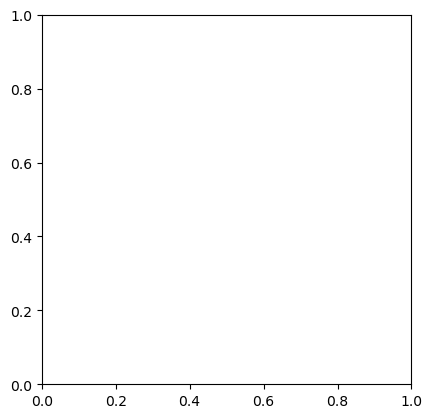

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
new_img=path+'//'+image_list[0]
new_img=np.asarray(new_img)
plt.imshow(new_img)

In [66]:
number = 1
formatted_number = "{:03d}".format(number)
print(formatted_number) 

001
